<a href="https://www.kaggle.com/code/lonnieqin/bird-species-classification-with-efficientnet?scriptVersionId=122916113" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Bird Species Classification with EfficientNet
## Table of Contents
* Overview
* Import Libraries
* Configuration
* Helper Functions
* Load data
* Exploratory Data Analysis
* Create TensorFlow Dataset
* Model Development
* Model Evaluation
* Create submission file
* Conclusion

## Overview
In this notebook, I will create a Bird Species Classification Model from scratch. I will train this model using [BirdCLEF 2023 competition dataset](https://www.kaggle.com/competitions/birdclef-2023), this dataset contains 16941 audio files of 264 kinds of bird species. This is a audio classification problem, one way to solve this problem is to convert audio files to spectrogram images and build an image classifier. Here are basic steps:
* Load and preprocess sound files using tensorflow-io.
* Randomly sample 5-second sound clip files.
* Convert sound files to spectrogram image with (256, 256, 3) shape.
* Create training and validation TensorFlow dataset.
* Create an image classification model using EfficientNet backbone that can accepts image with shape (n, 256, 256, 3) as input and output probabilities with shape (n, 264).


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow_io as tfio
from IPython.display import Audio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics
import json
import tensorflow as tf
import os
import glob

## Configuration

In [2]:
class CFG:
    image_size = [256, 256]
    is_training = False
    epochs = 10

## Helper Functions

In [3]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score


def preprocess(audio_url, label):
    audio_string = tf.io.read_file(audio_url)
    audio = tfio.audio.decode_vorbis(audio_string)
    audio_tensor = tf.squeeze(audio, axis=[-1])
    diff = tf.cast(tf.shape(audio_tensor)[0] - 5 * 32000, tf.float32)
    begin = tf.cast(tf.random.uniform(shape=()) * diff, tf.int32)
    start_position = tf.where(diff > 0, begin, 0)
    end_position = tf.where(diff > 0, start_position + 5 * 32000, tf.shape(audio_tensor)[0])
    audio_tensor = audio_tensor[start_position:end_position]
    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
    spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
    spectrogram = tfio.audio.dbscale(spectrogram, top_db=80)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, CFG.image_size)
    spectrogram = (spectrogram - tf.reduce_min(spectrogram)) / (tf.reduce_max(spectrogram) - tf.reduce_min(spectrogram)) * 255.0
    return spectrogram, label

def preprocess_test(audio_tensor):
    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
    spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
    spectrogram = tfio.audio.dbscale(spectrogram, top_db=80)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, CFG.image_size)
    spectrogram = (spectrogram - tf.reduce_min(spectrogram)) / (tf.reduce_max(spectrogram) - tf.reduce_min(spectrogram)) * 255.0
    return tf.expand_dims(spectrogram, axis=0)

def make_dataset(df, batch_size=128, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df["file_path"], df["label"]))
    ds = ds.map(preprocess)
    if shuffle:
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def make_inference(tensor):
    image = preprocess_test(tensor)
    return model.predict(image)

def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
      ) -> np.ndarray:
    
    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

def ensure_sample_rate(waveform, original_sample_rate,
                       desired_sample_rate=32000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        waveform = tfio.audio.resample(waveform, original_sample_rate, desired_sample_rate)
    return desired_sample_rate, waveform

def preprocess_test(audio_tensor):
    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
    spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
    spectrogram = tfio.audio.dbscale(spectrogram, top_db=80)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, (256, 256))
    spectrogram = (spectrogram - tf.reduce_min(spectrogram)) / (tf.reduce_max(spectrogram) - tf.reduce_min(spectrogram)) * 255.0
    return spectrogram

def predict_for_sample(filename, sample_submission, frame_limit_secs=None):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    audio = tfio.audio.AudioIOTensor(filename)
    sample_rate = audio.rate.numpy()
    audio_tensor = tf.squeeze(audio[0:], axis=[-1])
    sample_rate, wav_data = ensure_sample_rate(audio_tensor, sample_rate)
    fixed_tm = frame_audio(wav_data)
    frame = 5
    all_logits = make_inference(fixed_tm[:1])
    for window in fixed_tm[1:]:
        if frame_limit_secs and frame > frame_limit_secs:
            continue
        logits = make_inference(window[np.newaxis, :])
        all_logits = np.concatenate([all_logits, logits], axis=0)
        frame += 5
    frame = 5
    all_probabilities = []
    for frame_logits in all_logits:
        probabilities = tf.nn.softmax(frame_logits).numpy()
        ## set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame), labels] = probabilities
        frame += 5

## Load data

In [4]:
train = pd.read_csv("../input/birdclef-2023/train_metadata.csv")
train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [5]:
submission = pd.read_csv("../input/birdclef-2023/sample_submission.csv")
submission.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
labels = list(submission.columns)
labels.remove("row_id")
print(labels)

['abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1', 'affeag1', 'afgfly1', 'afghor1', 'afmdov1', 'afpfly1', 'afpkin1', 'afpwag1', 'afrgos1', 'afrgrp1', 'afrjac1', 'afrthr1', 'amesun2', 'augbuz1', 'bagwea1', 'barswa', 'bawhor2', 'bawman1', 'bcbeat1', 'beasun2', 'bkctch1', 'bkfruw1', 'blacra1', 'blacuc1', 'blakit1', 'blaplo1', 'blbpuf2', 'blcapa2', 'blfbus1', 'blhgon1', 'blhher1', 'blksaw1', 'blnmou1', 'blnwea1', 'bltapa1', 'bltbar1', 'bltori1', 'blwlap1', 'brcale1', 'brcsta1', 'brctch1', 'brcwea1', 'brican1', 'brobab1', 'broman1', 'brosun1', 'brrwhe3', 'brtcha1', 'brubru1', 'brwwar1', 'bswdov1', 'btweye2', 'bubwar2', 'butapa1', 'cabgre1', 'carcha1', 'carwoo1', 'categr', 'ccbeat1', 'chespa1', 'chewea1', 'chibat1', 'chtapa3', 'chucis1', 'cibwar1', 'cohmar1', 'colsun2', 'combul2', 'combuz1', 'comsan', 'crefra2', 'crheag1', 'crohor1', 'darbar1', 'darter3', 'didcuc1', 'dotbar1', 'dutdov1', 'easmog1', 'eaywag1', 'edcsun3', 'egygoo', 'equaka1', 'eswdov1', 'eubeat1', 'fatrav1', 'f

## Exploratory Data Analysis

There are 264 kinds of birds. Some kind of birds only have 1 sample. It's even challenging to create a Cross Validation Strategy. Before I figure out a better CV strategy, I will start with train validation split with random seed 42.

In [7]:
train.primary_label.value_counts()

barswa     500
wlwwar     500
thrnig1    500
eaywag1    500
comsan     500
          ... 
lotcor1      1
whctur2      1
whhsaw1      1
afpkin1      1
crefra2      1
Name: primary_label, Length: 264, dtype: int64

In [8]:
train.secondary_labels.value_counts()

[]                                              14636
['combul2']                                       169
['somgre1']                                        76
['rindov']                                         74
['wlwwar']                                         64
                                                ...  
['klacuc1', 'laudov1']                              1
['carcha1', 'hadibi1', 'helgui']                    1
['grbcam1', 'gyhspa1', 'laudov1']                   1
['carcha1', 'reftin1']                              1
['grbcam1', 'gryapa1', 'ndcsun2', 'yertin1']        1
Name: secondary_labels, Length: 751, dtype: int64

In [9]:
train["label"] = train["primary_label"].map(lambda primary_label: labels.index(primary_label))
train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,0
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,0
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg,0
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg,0
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg,0


In [10]:
train["file_path"] = train["filename"].apply(lambda filename: os.path.join(f"/kaggle/input/birdclef-2023/train_audio/{filename}"))
train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label,file_path
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,0,/kaggle/input/birdclef-2023/train_audio/abethr...
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,0,/kaggle/input/birdclef-2023/train_audio/abethr...
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg,0,/kaggle/input/birdclef-2023/train_audio/abethr...
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg,0,/kaggle/input/birdclef-2023/train_audio/abethr...
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg,0,/kaggle/input/birdclef-2023/train_audio/abethr...


### Number Of Samples

In [11]:
len(train)

16941

### Create Audio Tensor
Let's create an Audio Tensor and play the sound.

In [12]:
audio = tfio.audio.AudioIOTensor("/kaggle/input/birdclef-2023/train_audio/blakit1/XC115289.ogg")
audio_tensor = tf.squeeze(audio[0:], axis=[-1])
Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

Show this audio clip in graph.

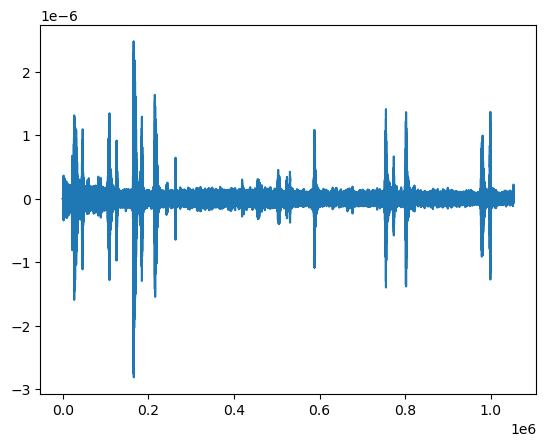

In [13]:
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
plt.figure()
plt.plot(tensor.numpy())

Show this audio clip to spectrogram.

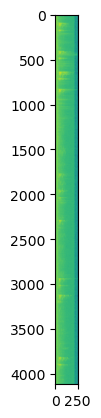

In [14]:
# Convert to spectrogram
tensor = tf.cast(audio_tensor, tf.float32) 
spectrogram = tfio.audio.spectrogram(tensor, nfft=512, window=512, stride=256)
spectrogram = tf.math.log(spectrogram)
plt.imshow(spectrogram)

The shape of spectrogram of a 5-second audio clip will be about (625, 257), for simplicity I will use (256, 256) as shape of image classification model input.

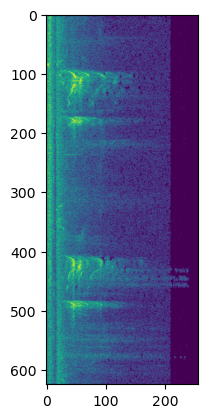

In [15]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(tensor[0:audio.rate * 5], nfft=512, window=512, stride=256)
spectrogram = tfio.audio.dbscale(spectrogram, top_db=80)

spectrogram = (spectrogram - tf.reduce_min(spectrogram)) / (tf.reduce_max(spectrogram) - tf.reduce_min(spectrogram)) * 255.0
plt.figure()
plt.imshow(spectrogram.numpy())

## Create TensorFlow Dataset

In [16]:
train_df, valid_df = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label,file_path
5217,comsan,[],['nocturnal flight call'],49.6276,0.6812,Actitis hypoleucos,Common Sandpiper,Loan Delpit,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/555291,comsan/XC555291.ogg,74,/kaggle/input/birdclef-2023/train_audio/comsan...
2078,blakit1,[],[''],39.1782,16.7828,Milvus migrans,Black Kite,Gianluca Congi,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://xeno-canto.org/695515,blakit1/XC695515.ogg,29,/kaggle/input/birdclef-2023/train_audio/blakit...
14099,thrnig1,[],['song'],59.2598,15.4135,Luscinia luscinia,Thrush Nightingale,Jan-Rune Ericson,Creative Commons Attribution-NonCommercial-Sha...,2.0,https://www.xeno-canto.org/475590,thrnig1/XC475590.ogg,221,/kaggle/input/birdclef-2023/train_audio/thrnig...
5446,comsan,[],['nocturnal flight call'],48.0372,-4.8622,Actitis hypoleucos,Common Sandpiper,Stanislas Wroza,Creative Commons Attribution-NonCommercial-Sha...,4.0,http://xeno-canto.org/678534,comsan/XC678534.ogg,74,/kaggle/input/birdclef-2023/train_audio/comsan...
12824,somgre1,[],['song'],-32.2321,24.4936,Andropadus importunus,Sombre Greenbul,Alan Collett,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/626173,somgre1/XC626173.ogg,201,/kaggle/input/birdclef-2023/train_audio/somgre...


In [18]:
valid_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,label,file_path
12211,rindov,[],['song'],-33.5977,26.7600,Streptopelia capicola,Ring-necked Dove,Tim Cockcroft,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/655030,rindov/XC655030.ogg,185,/kaggle/input/birdclef-2023/train_audio/rindov...
16190,woosan,[],['nocturnal flight call'],43.0353,-1.0203,Tringa glareola,Wood Sandpiper,Louis Sallé,Creative Commons Attribution-NonCommercial-Sha...,5.0,http://xeno-canto.org/689928,woosan/XC689928.ogg,247,/kaggle/input/birdclef-2023/train_audio/woosan...
10104,litswi1,['somgre1'],['call'],-6.7832,39.2033,Apus affinis,Little Swift,Louis A. Hansen,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/443707,litswi1/XC443707.ogg,136,/kaggle/input/birdclef-2023/train_audio/litswi...
10710,piekin1,[],['call'],-8.1871,36.6653,Ceryle rudis,Pied Kingfisher,Louis A. Hansen,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/515955,piekin1/XC515955.ogg,162,/kaggle/input/birdclef-2023/train_audio/piekin...
7699,grbcam1,[],['call'],-33.5940,26.8969,Camaroptera brachyura,Green-backed Camaroptera,Tim Cockcroft,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/291506,grbcam1/XC291506.ogg,103,/kaggle/input/birdclef-2023/train_audio/grbcam...


In [19]:
valid_ds = make_dataset(valid_df, shuffle=False)

The input shape and output shape of training data will be (n, 256, 256, 1) and (n). During training, target label will be converted to onehot tensor with 264 classes.

In [20]:
for X, y in valid_ds.take(1):
    print(X.shape, y.shape)

(128, 256, 256, 1) (128,)


## Model Development

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.concat (TFOpLambda)         (None, 256, 256, 3)  0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 efficientnetv2-s (Functional)  (None, 1280)         20331360    ['tf.concat[0][0]']          

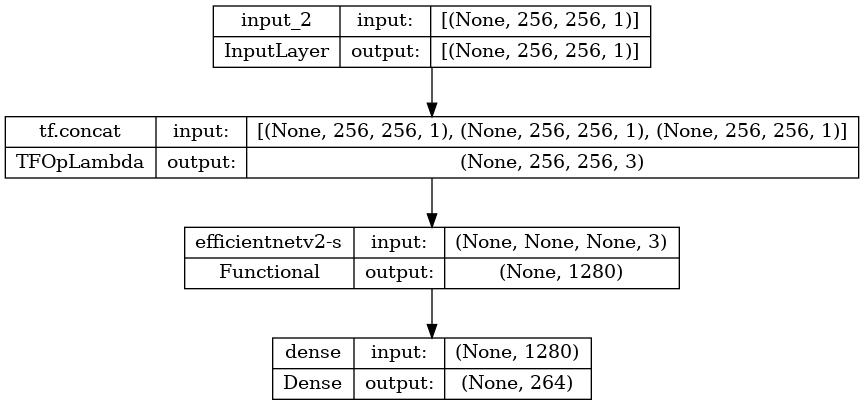

In [21]:
if CFG.is_training:
    train_ds = make_dataset(train_df)
    def get_model():
        inputs = tf.keras.Input(shape=(CFG.image_size[0], CFG.image_size[1], 1))
        image_inputs = tf.concat([
            inputs,
            inputs,
            inputs
        ], axis=-1)
        vector = efficent_net(image_inputs)
        output = tf.keras.layers.Dense(264, activation="softmax")(vector)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-3), metrics=["accuracy"])
        return model
    efficent_net = tf.keras.applications.EfficientNetV2S(include_top=False, pooling="max")
    efficent_net.trainable = False
    efficent_net.summary()
    model = get_model()
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "model.h5", 
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            min_delta=1e-4, 
            patience=10
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=0.3,
            patience=2, 
            min_lr=1e-7
        ),
        tf.keras.callbacks.TerminateOnNaN()
    ]
    model.fit(train_ds, epochs=CFG.epochs, validation_data=valid_ds, callbacks=callbacks)
else:
    model = tf.keras.models.load_model("/kaggle/input/bird-clef/model.h5")
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Model Evaluation

In [22]:
y_preds = model.predict(valid_ds)
y_pred_labels = np.argmax(y_preds, axis=1)

27/27 [==============================] - 531s 19s/step


In [23]:
submission_df = pd.DataFrame({"row_id": valid_df.index}).copy()
for i, column in enumerate(labels):
    submission_df[column] = y_preds[:, i]
true_labels = list(valid_df["label"])
solution_df = pd.DataFrame({"row_id": valid_df.index}).copy()
for column in labels:
    solution_df[column] = 0
for i in range(len(valid_df)):
    secondary_labels = valid_df.iloc[i]["secondary_labels"]
    secondary_labels = secondary_labels.replace("\'", "\"")
    arr = json.loads(secondary_labels)
    solution_df.loc[i, labels[true_labels[i]]] = 1
    if len(arr) > 0:
        for secondary_label in arr:
            idx = labels.index(secondary_label)
            if idx >= 0 and idx < len(labels):
                solution_df.loc[i, labels[true_labels[idx]]] = 1
score = padded_cmap(solution_df, submission_df)
print(f"CV:{score}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


CV:0.5803753417718461


## Create Submission file

In [24]:
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
submission = pd.read_csv("../input/birdclef-2023/sample_submission.csv")
submission[labels] = submission[labels].astype(np.float32)
for filename in test_samples:
    predict_for_sample(filename, submission, frame_limit_secs=15)
submission.to_csv("submission.csv", index=False)
submission.head()

1/1 [==============================] - 0s 170ms/step


,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0.003773,0.003778,0.003774,0.003772,0.003817,0.003772,0.003773,0.003772,0.003775,...,0.003772,0.003772,0.003776,0.003772,0.003772,0.003772,0.003772,0.003772,0.003772,0.003772
1,soundscape_29201_10,0.003792,0.003779,0.003773,0.003773,0.003773,0.003773,0.003773,0.003773,0.003774,...,0.003773,0.003773,0.003775,0.003773,0.003773,0.003773,0.003773,0.003773,0.003773,0.003773
2,soundscape_29201_15,0.003775,0.003774,0.003772,0.003772,0.003773,0.003772,0.003772,0.003773,0.003772,...,0.003772,0.003772,0.003917,0.003773,0.003772,0.003772,0.003772,0.003772,0.003772,0.003772


## Conclusion
This Model can achieve about 0.58 CV and 0.71 LB, a little bit lower than the [baseline notebook](https://www.kaggle.com/code/philculliton/inferring-birds-with-kaggle-models), good enough for a notebook written from scratch. There's still a lot of space to improve. For example:
* Create a better cross validation strategy.
* Better way to create spectrogram image.
* Better sampling method.
* Better Neural Architecture and better pretrained model.
* Build a Sequence Model that can handle long spectrogram image.